In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d thienkhonghoc/affectnet

Dataset URL: https://www.kaggle.com/datasets/thienkhonghoc/affectnet
License(s): unknown
100% 1.75G/1.75G [01:21<00:00, 23.8MB/s]
100% 1.75G/1.75G [01:21<00:00, 23.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/affectnet.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = "/content/AffectNet/train"
val_dir = "/content/AffectNet/val"
test_dir ="/content/AffectNet/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]


In [ ]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1/255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True ,
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = val_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 30043 images belonging to 8 classes.
Found 7510 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


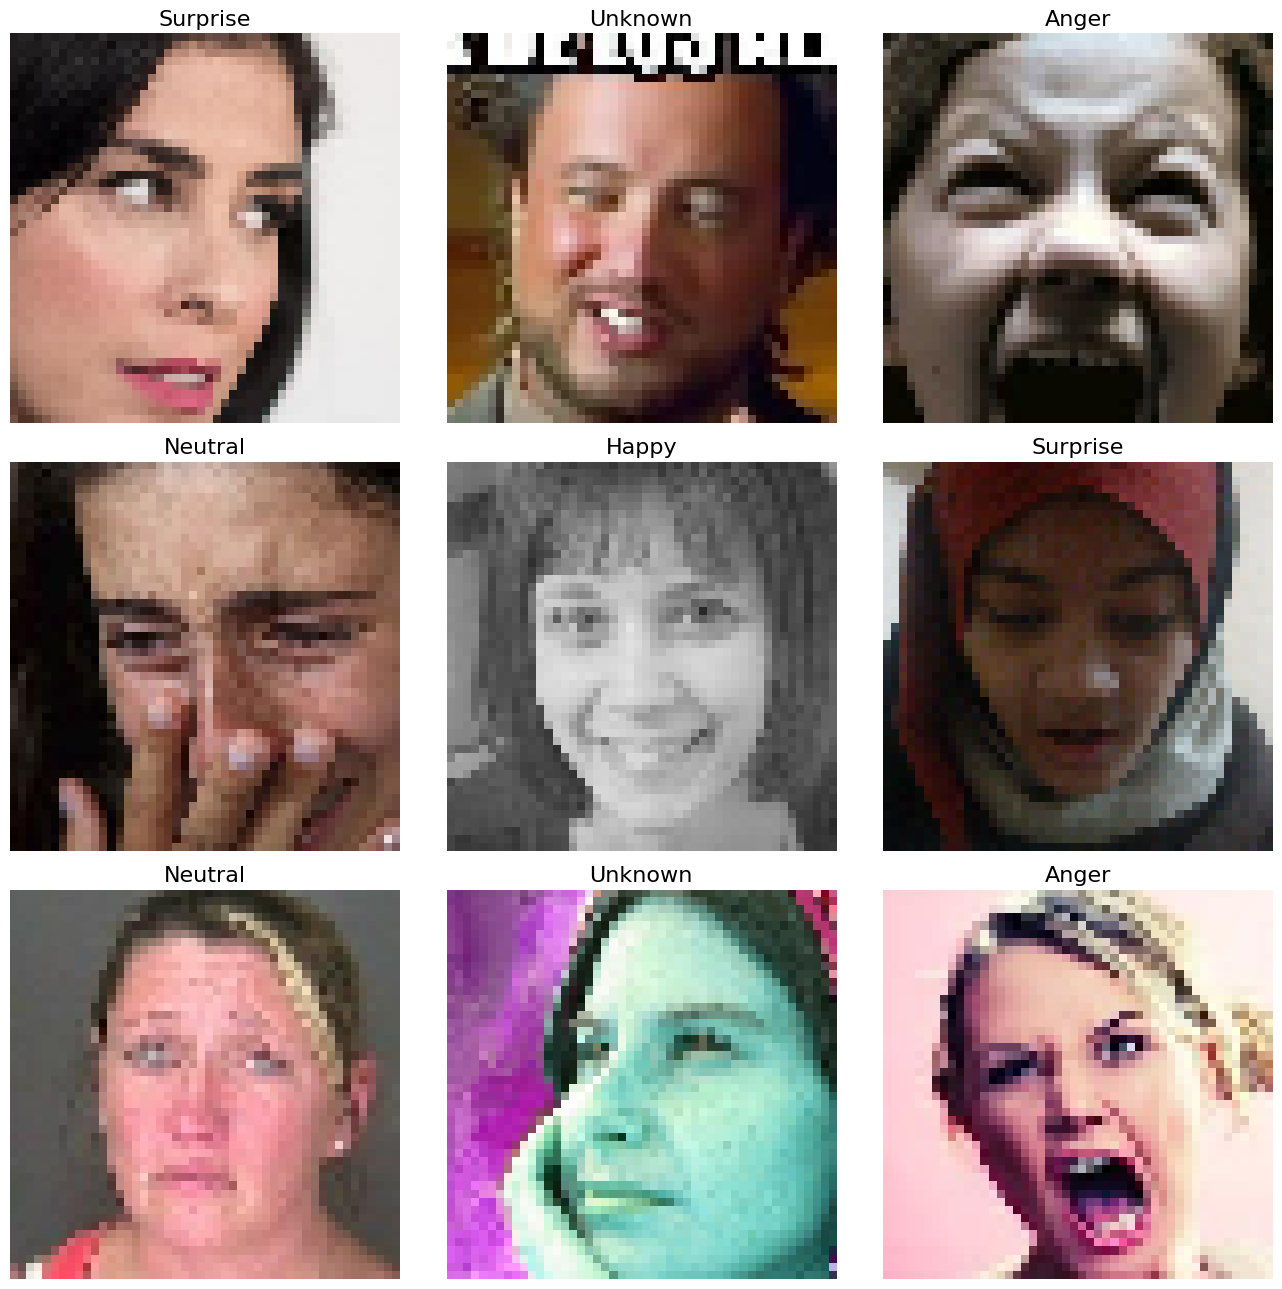

In [ ]:

# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    # The number of classes has been updated from 7 to 8
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1)
# Added a check to handle indices out of range in CLASS_LABELS
labels = [CLASS_LABELS[idx] if idx < len(CLASS_LABELS) else "Unknown" for idx in class_idxs]
display_nine_images(images, labels)

In [ ]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             # Removed the extra class from the count
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)[:-1]] ,
             color = np.unique(train_generator.classes)[:-1] ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

    return model

In [ ]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 1, 1, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         426,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,860,679 (52.87 MB)

 Trainable params: 1,217,799 (4.65 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [ ]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    # Changed NUM_CLASSES to 8 to match the number of classes in the dataset
    x = tf.keras.layers.Dense(8, activation="softmax", name="classification")(x)

    return x

In [ ]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()


# ipython-input-11-a568e1afe3d2
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

# model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
#                 loss='categorical_crossentropy',
#                 metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = pd.DataFrame(history_.history) # Initialize history to an empty dataframe if you intend to concatenate later
history = pd.concat([history, pd.DataFrame(history_.history)], ignore_index=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 1, 1, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         426,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,861,192 (52.88 MB)

 Trainable params: 1,218,312 (4.65 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

Epoch 1/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 414s 550ms/step - accuracy: 0.1352 - loss: 12.4997 - val_accuracy: 0.1328 - val_loss: 4.4216
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 170s 354ms/step - accuracy: 0.1653 - loss: 3.6447 - val_accuracy: 0.2168 - val_loss: 2.4554
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 172s 296ms/step - accuracy: 0.2251 - loss: 2.2033 - val_accuracy: 0.2617 - val_loss: 1.9598
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 139s 290ms/step - accuracy: 0.2635 - loss: 1.9046 - val_accuracy: 0.2720 - val_loss: 1.9233
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 159s 336ms/step - accuracy: 0.2964 - loss: 1.7964 - val_accuracy: 0.3232 - val_loss: 1.7408
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 181s 293ms/step - accuracy: 0.3455 - loss: 1.7374 - val_accuracy: 0.3678 - val_loss: 1.6736
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 137s 290ms/step - accuracy: 0.3555 - loss: 1.7054 - val_accuracy: 0.3687 - val_loss: 1.6880
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 142s 290ms/step - accuracy: 0.3724 

In [ ]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [ ]:
import pandas as pd
import numpy as np

epochs = range(1, 11)
accuracy = np.random.rand(10)
val_accuracy = np.random.rand(10)

history = pd.DataFrame({'epochs': epochs, 'accuracy': accuracy, 'val_accuracy': val_accuracy})

# Plotting with Plotly Express
import plotly.express as px

# Using the actual DataFrame 'history' with data
fig = px.line(history, x='epochs', y=['accuracy', 'val_accuracy'], markers=True)

# Updating axes titles
fig.update_xaxes(title="Number of Epochs")
fig.update_yaxes(title="Accuracy")

# Updating layout
fig.update_layout(
    title="Accuracy vs Number of Epochs",
    title_x=0.5,
    title_y=0.94,
    xaxis_title="Number of Epochs",
    yaxis_title="Accuracy",
    showlegend=True
)

# Show the plot
fig.show()


In [ ]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4653 - loss: 1.5939
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]


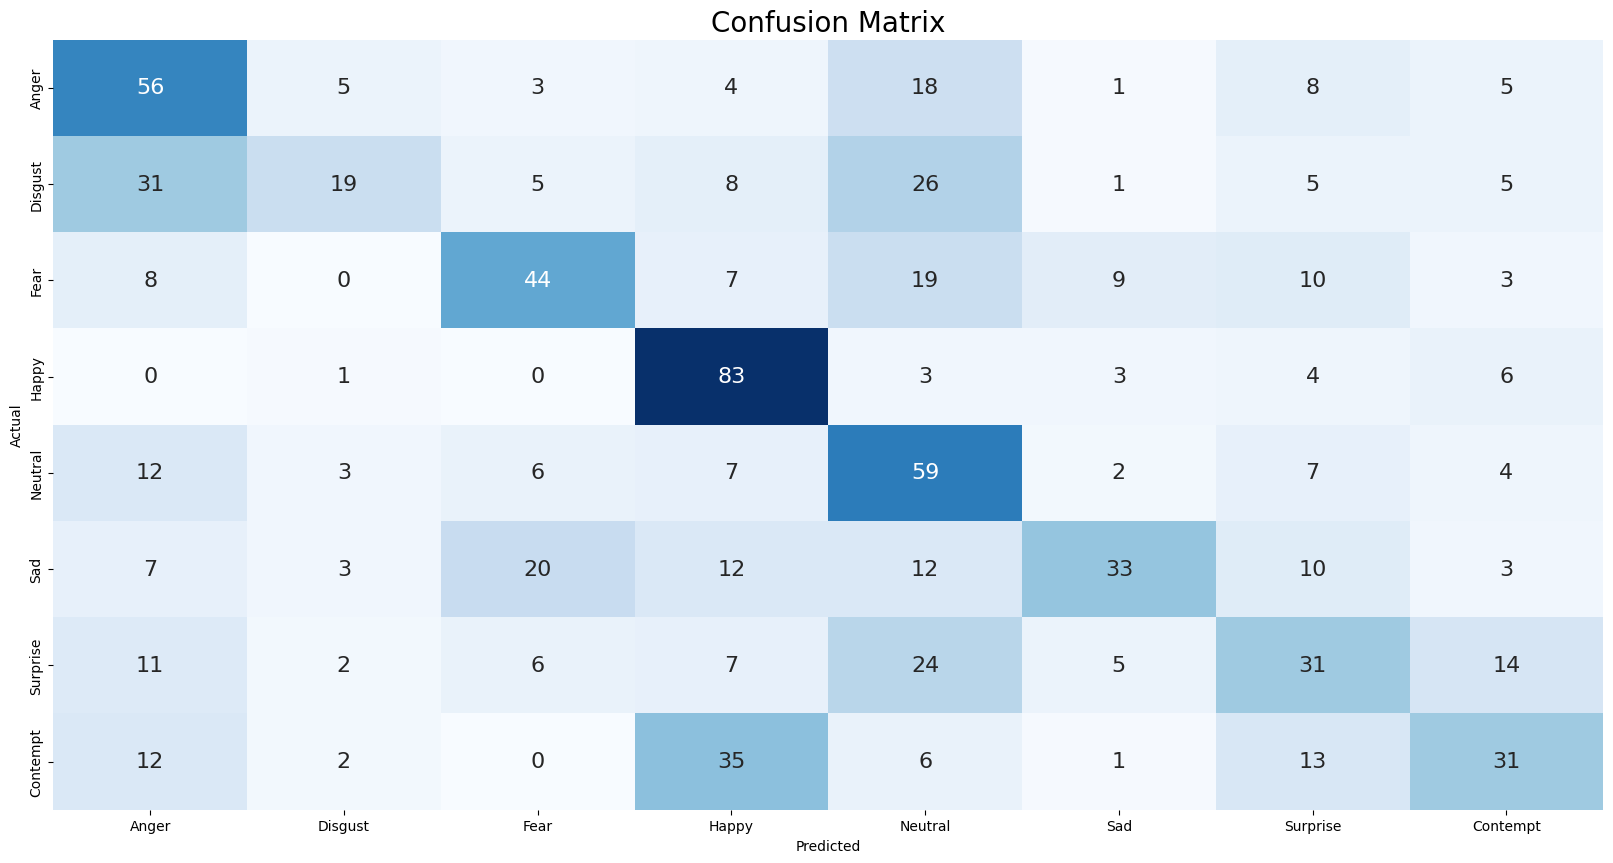

In [ ]:
!pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Check unique values in y_preds and y_test
print(np.unique(y_preds))
print(np.unique(y_test))

# Update CLASS_LABELS to include all classes found in y_preds and y_test
CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise', 'Contempt'] # Add 'Contempt' to CLASS_LABELS

# Recalculate cm_data with the updated CLASS_LABELS
cm_data = confusion_matrix(y_test , y_preds)

cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.41      0.56      0.47       100
           1       0.54      0.19      0.28       100
           2       0.52      0.44      0.48       100
           3       0.51      0.83      0.63       100
           4       0.35      0.59      0.44       100
           5       0.60      0.33      0.43       100
           6       0.35      0.31      0.33       100
           7       0.44      0.31      0.36       100

    accuracy                           0.45       800
   macro avg       0.47      0.45      0.43       800
weighted avg       0.47      0.45      0.43       800



ROC AUC score: 0.8096131696428571


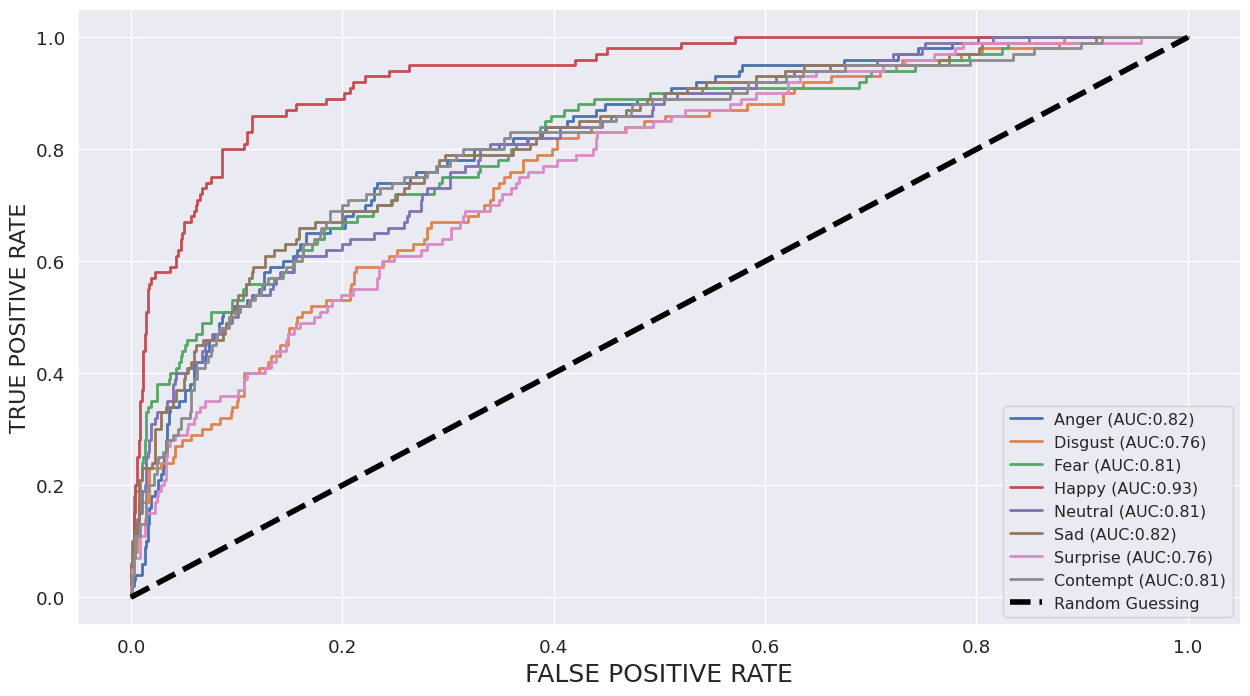

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8146553571428572


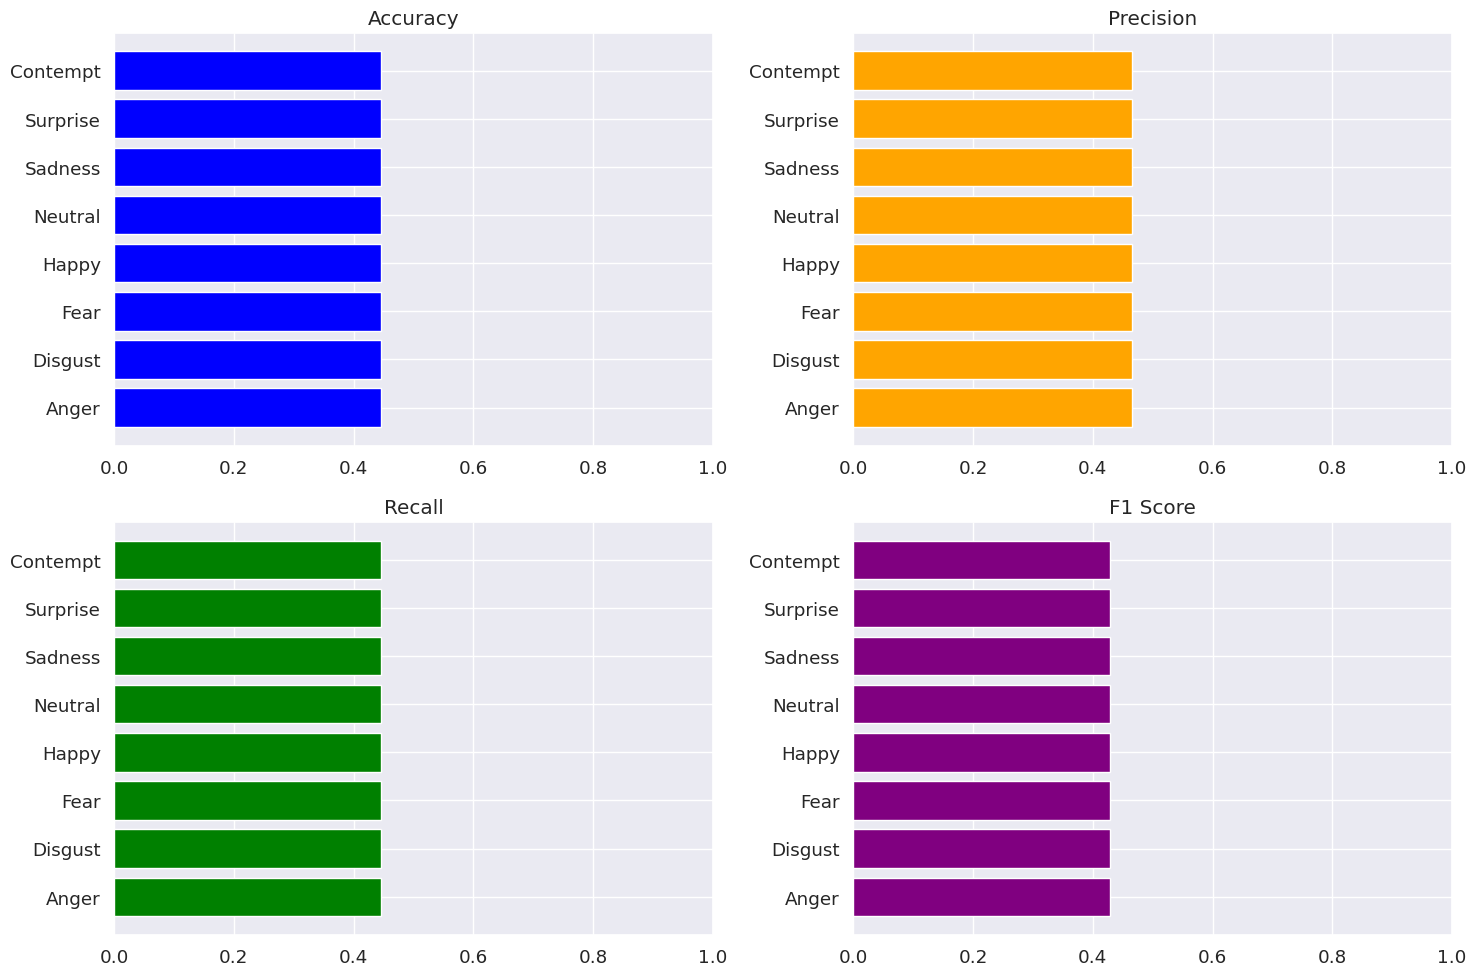

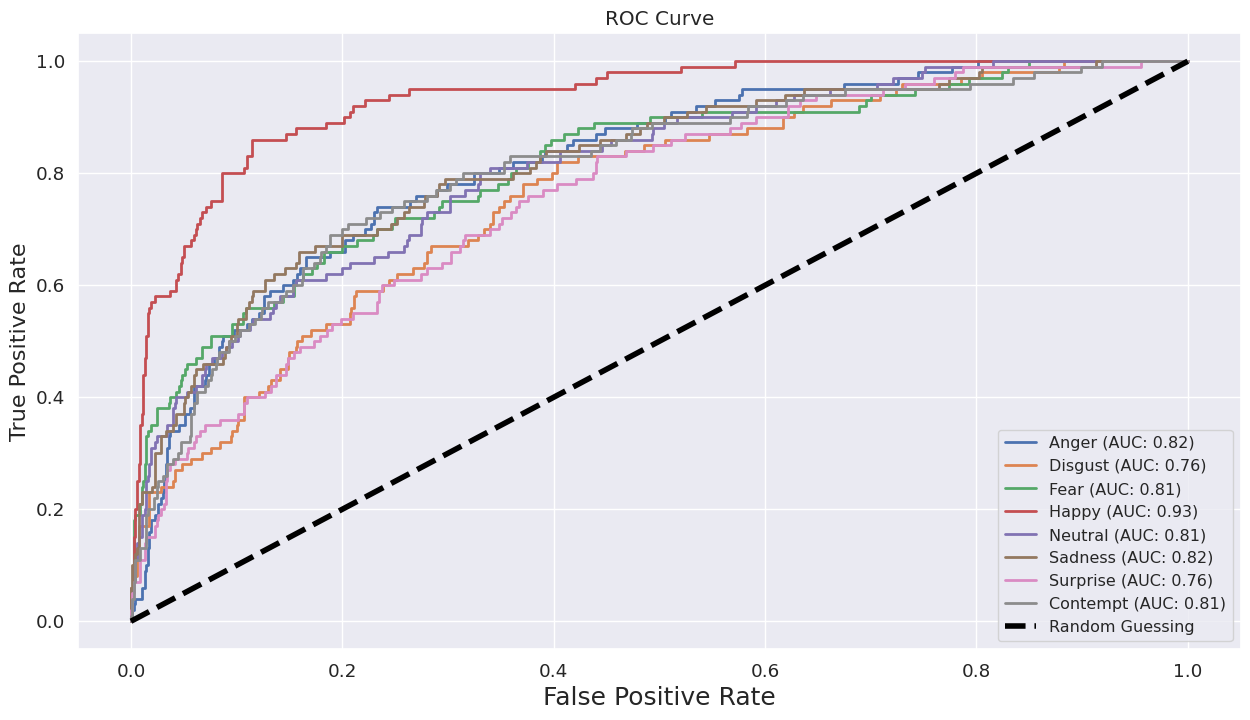

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Assuming y_test and preds are defined and are your true labels and predicted probabilities

def plot_metrics(y_test, preds, class_labels):
    # Initialize the plot for accuracy, precision, recall, F1 Score
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # Calculate metrics
    accuracy = accuracy_score(y_test, np.argmax(preds, axis=1))
    precision = precision_score(y_test, np.argmax(preds, axis=1), average='macro')
    recall = recall_score(y_test, np.argmax(preds, axis=1), average='macro')
    f1 = f1_score(y_test, np.argmax(preds, axis=1), average='macro')

    # Accuracy
    ax[0, 0].barh(class_labels, [accuracy] * len(class_labels), color='blue')
    ax[0, 0].set_title('Accuracy')
    ax[0, 0].set_xlim(0, 1)

    # Precision
    ax[0, 1].barh(class_labels, [precision] * len(class_labels), color='orange')
    ax[0, 1].set_title('Precision')
    ax[0, 1].set_xlim(0, 1)

    # Recall
    ax[1, 0].barh(class_labels, [recall] * len(class_labels), color='green')
    ax[1, 0].set_title('Recall')
    ax[1, 0].set_xlim(0, 1)

    # F1 Score
    ax[1, 1].barh(class_labels, [f1] * len(class_labels), color='purple')
    ax[1, 1].set_title('F1 Score')
    ax[1, 1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Plot ROC AUC
    fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

    # Binarize the output
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)

    for (idx, c_label) in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, idx], preds[:, idx])
        c_ax.plot(fpr, tpr, lw=2, label='%s (AUC: %0.2f)' % (c_label, auc(fpr, tpr)))

    c_ax.plot([0, 1], [0, 1], 'black', linestyle='dashed', lw=4, label='Random Guessing')
    c_ax.set_xlabel('False Positive Rate', fontsize=18)
    c_ax.set_ylabel('True Positive Rate', fontsize=16)
    c_ax.legend(fontsize=11.5)
    c_ax.set_title('ROC Curve')
    plt.show()

# Example usage:
# y_test should contain your true labels
# preds should contain the predicted probabilities for each class
Classes = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise' , 'Contempt']  # Your class labels

# Call the function
plot_metrics(y_test, preds, Classes)


In [ ]:
model.save('Densetnet.h5')